# How Flights Delay?

In this project we explored through our dataset and set up a model predicting delay for given conditions, and based on this model we can give advice on choosing flights on different seasons, airlines and hours. Due to the constraint on difficulties getting whole world delay dataset, and the US is the largest flight country, in our project the delay analysis is mostly based on the US data.

We want to know :
* What will affect mostly on the delay of a flight, could it be departure season, hours or airlines? 
* And can we predict if and how long will a flight delays given certain situations? 
* Or, if some one wants to fly from city A to city B, can we give him or her some advices on choose flights based on the delay rate?

Generally, what we did can be listed as:

1. Data exploration (both 

## Table of contents

* [Data Exploration](#Data-Exploration)

    1. [Openflight](#Openflight)
    
    1.1 [Overview of Openflight](#Overview-of-Openflight)
    
    1.2 [Analysis based on flight capacity](#Analysis-based-on-flight-capacity)
    
    1.3 [Create and draw graph for Openflight](#Create-and-draw-graph-for-Openflight)
    
    In this part we created graph with airports as nodes and distance as weights. And on the spectral graph we can clearly see regional flights are clustered together.
    
    2. [FlightDelay]


* [Data Exploitation]


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import sparse
import scipy.sparse.linalg
from pyunlocbox import functions, solvers

import networkx as nx
import missingno as msno

from math import radians,cos,sin,asin,sqrt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

## Data Exploration

### Openflight
This part is used for data pre-processing and data exploration for the dataset of `OpenFlight` dataset.

In [2]:
routenames = ['Airline', 'Airline_ID', 'Src_IATA', 'Src_ID', 
            'Des_IATA', 'Des_ID', 'Codeshare', 'Stops', 'Equipment']

routes = pd.read_csv("../routes.dat",header = None,names = routenames,encoding = 'utf-8', na_values='\\N')
routes.dropna(subset=["Airline_ID"], inplace=True)

airlines = pd.read_csv("../airlines.dat",names = ['Airline_ID','Name','Alias','IATA','ICAO','Callsign','Country','Active'])

airports = pd.read_csv("../airports.dat",names = ['Airport_ID','Name','City','Country','IATA','ICAO','Latitude','Longitude',
                                               'Altitude','Timezone','DST','TZ database','Type','Source'], na_values='\\N')

---
### Overview of Openflight

Dataset is obtained from: https://openflights.org/data.html

This OpenFlights/Airline Route Mapper Route Database contains 67,663 routes (EDGES) between 3,321 airports (NODES) on 548 airlines spanning the globe. 

In `routes` data, we have airline, airline ID, source airport IATA code, destination airport IATA code and unique open flight ID, stops and equipment. 

In `airline` data, we have airline ID, airline name, alias, IATA code, ICTO code and country of that airline. 

In `airports` data, we have airport open flight ID, IATA and ICTO code and its latitude and longitude and time zone. Below we use missingno to show the overall data description of each data set.


Below we use `msno` to show the information of dataset. White lines mean missing value. 

In `routes` we have a dataset with size 67184\*9. Columns include airline IATA code, airline unique ID, departure and arrival airport IATA code, code share, stop number of this flight and equipment(the aircraft type).

In [3]:
routes.head(2)

,Airline,Airline_ID,Src_IATA,Src_ID,Des_IATA,Des_ID,Codeshare,Stops,Equipment
0,2B,410.0,AER,2965.0,KZN,2990.0,NaN,0,CR2
1,2B,410.0,ASF,2966.0,KZN,2990.0,NaN,0,CR2


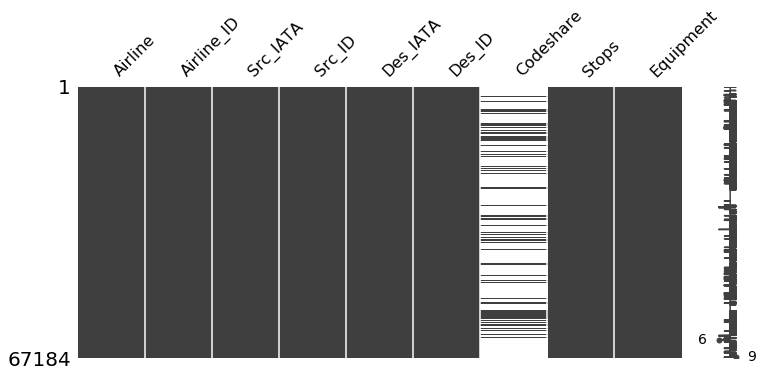

In [4]:
msno.matrix(routes,figsize=(12, 5))#.info()

In `airports` we have a dataset with size 7543\*14. Columns include airport ID, airport name, city, country, IATA and ICAO code of this airport, latitude and longitude, altitude, timezone DST, timezone database, type and data source.

In [5]:
airports.head(2)

,Airport_ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TZ database,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.08169,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.20708,145.789001,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports


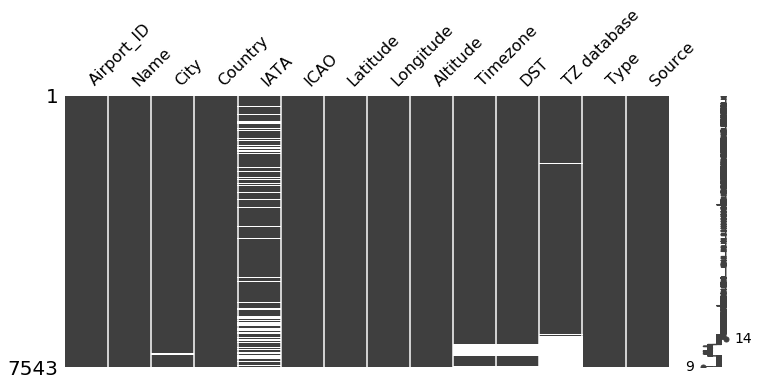

In [6]:
msno.matrix(airports,figsize=(12, 5))#.info()

In `airlines` we have a dataset with size 6162\*8. Columns include airline ID, name, alias, IATA and ICAO code, country and the activeness.

In [7]:
airlines.head(2)

,Airline_ID,Name,Alias,IATA,ICAO,Callsign,Country,Active
0,-1,Unknown,\N,-,NaN,\N,\N,Y
1,1,Private flight,\N,-,NaN,NaN,NaN,Y


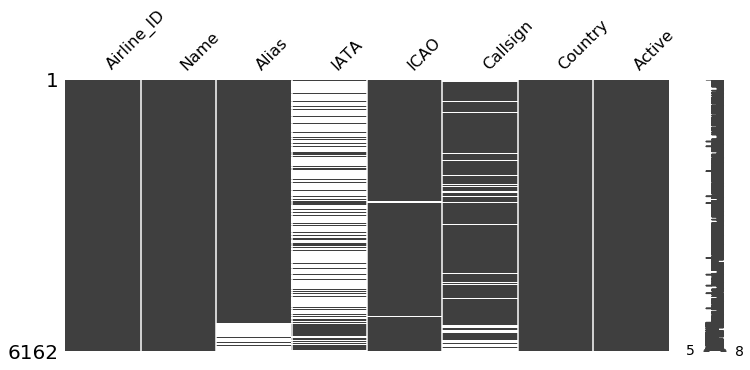

In [8]:
msno.matrix(airlines,figsize=(12, 5))#.info()

---
### Analysis based on flight capacity
In this part we are going to create the adjacency matrix, where the node is airport and the weight of links will be either the routes number between two airports or the maximum capacity of aircrafts on their routes.

In `routes` the column `Equipment` contains the aircraft types of that routes. We calculated the capacity of that route using the maximum of the aircraft capacity. For routes where multi aircrafts are used, we calculated the averaged capacity. And the `Equipment` not in `capacity.xlsx` are mainly helicopters and other small planes, which are not commercially used, so dropping these routes will not affect much.

In [9]:
routes.drop(columns=['Airline','Airline_ID','Codeshare'],inplace=True)
routes.dropna(subset=['Equipment'],inplace=True)
routes.reset_index(level=0, drop=True,inplace=True)

In [10]:
capacity = pd.read_excel('../capacity.xlsx',header=None,index_col=0)
capacity.columns = ['Equipment','Capacity','test']
capacity = capacity[['Equipment','Capacity']]

In [11]:
capacity.dropna(subset=['Capacity'],inplace=True)
capacity.Equipment = capacity.Equipment.astype('str')
capacity.set_index('Equipment',inplace=True)

In [12]:
cap_list = []
for i in range(len(routes)):
    tmp = routes.iloc[i].Equipment#.get_values()
    cap = []
    for equip in tmp.split():
        try:
            cap_tmp = capacity.loc[equip].Capacity
            cap.append(cap_tmp)
        except:
            continue
    cap_list.append(np.mean(cap))

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
routes['Capacity'] = cap_list
routes.dropna(subset=['Capacity'],inplace=True)

In [14]:
src_cap = routes[['Src_ID','Capacity']].groupby('Src_ID').sum()
des_cap = routes[['Des_ID','Capacity']].groupby('Des_ID').sum()

In [15]:
# merge the capacity ('src_cap' for departure airport;'des_cap' for destination airport)
src_des_cap = pd.concat([src_cap,des_cap], axis=1, sort=True).fillna(0)
src_des_cap.columns = ['Src_cap','Des_cap']
src_des_cap.reset_index(level=0, inplace=True)
src_des_cap.rename(columns={'index':'Airport_ID'},inplace=True)
src_des_cap.head(2)

,Airport_ID,Src_cap,Des_cap
0,1.0,241.666667,241.666667
1,2.0,540.000000,540.000000


In [16]:
portgeo = pd.DataFrame(pd.concat([routes.Src_ID,routes.Des_ID],axis=0).drop_duplicates())
portgeo.rename(columns={0:'Airport_ID'},inplace=True)
portgeo.reset_index(level=0, drop=True,inplace=True)
portgeo = portgeo.merge(src_des_cap,on='Airport_ID')
portgeo.head(5)

,Airport_ID,Src_cap,Des_cap
0,2965.0,3537.333333,3537.333333
1,2966.0,820.000000,820.000000
2,2968.0,2584.000000,2584.000000
3,4029.0,53273.716667,53408.383333
4,6156.0,843.000000,843.000000


In [17]:
# the final .csv containing latittude, longitude, capcity and node index for each airport
portgeo = portgeo.merge(airports[['Name','City','Country','IATA','Latitude','Longitude','Airport_ID']],on='Airport_ID')
portgeo.head(5)

,Airport_ID,Src_cap,Des_cap,Name,City,Country,IATA,Latitude,Longitude
0,2965.0,3537.333333,3537.333333,Sochi International Airport,Sochi,Russia,AER,43.449902,39.956600
1,2966.0,820.000000,820.000000,Astrakhan Airport,Astrakhan,Russia,ASF,46.283298,48.006302
2,2968.0,2584.000000,2584.000000,Chelyabinsk Balandino Airport,Chelyabinsk,Russia,CEK,55.305801,61.503300
3,4029.0,53273.716667,53408.383333,Domodedovo International Airport,Moscow,Russia,DME,55.408798,37.906300
4,6156.0,843.000000,843.000000,Belgorod International Airport,Belgorod,Russia,EGO,50.643799,36.590099


In [18]:
#portgeo.to_csv('../portgeo.csv',index=False)
portgeo = pd.read_csv('../portgeo.csv')

Here we show the top 10 largest capacity airports. Comparing the list to the real top 10 busiest airports worldwide, we can see that two list overlap a lot.

In [19]:
portgeo.sort_values(by='Src_cap',ascending=False).head(10)

,Airport_ID,Src_cap,Des_cap,Name,City,Country,IATA,Latitude,Longitude
423,507.0,143397.716667,142622.800000,London Heathrow Airport,London,United Kingdom,LHR,51.470600,-0.461941
159,3682.0,141866.095238,139436.509524,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,33.636700,-84.428101
266,3364.0,115172.759524,114819.426190,Beijing Capital International Airport,Beijing,China,PEK,40.080101,116.584999
397,1382.0,113329.350000,111403.600000,Charles de Gaulle International Airport,Paris,France,CDG,49.012798,2.550000
409,340.0,106306.785714,105942.619048,Frankfurt am Main Airport,Frankfurt,Germany,FRA,50.033333,8.570556
326,3797.0,99766.800000,100187.400000,John F Kennedy International Airport,New York,United States,JFK,40.639801,-73.778900
298,3484.0,95866.950000,96717.783333,Los Angeles International Airport,Los Angeles,United States,LAX,33.942501,-118.407997
242,3930.0,94953.850000,95024.850000,Incheon International Airport,Seoul,South Korea,ICN,37.469101,126.450996
142,3316.0,94079.000000,95077.833333,Singapore Changi Airport,Singapore,Singapore,SIN,1.350190,103.994003
128,3885.0,88661.621429,88772.954762,Suvarnabhumi Airport,Bangkok,Thailand,BKK,13.681100,100.747002


And we can see that the US is the country with largest flight passengers.

In [20]:
portgeo.groupby('Country')['Src_cap','Des_cap'].sum().sort_values(by='Src_cap',ascending=False).head(5)

,Src_cap,Des_cap
Country,,
United States,1.769154e+06,1.767567e+06
China,1.309744e+06,1.309989e+06
United Kingdom,4.779132e+05,4.719609e+05
Spain,4.216310e+05,4.229192e+05
Germany,3.879360e+05,3.858549e+05


---
### Create and draw graph for Openflight
Below we created the graph using airports as nodes, distance of airports as weights.

In [34]:
df_tmp = routes.groupby(['Src_IATA','Des_IATA'])['Capacity'].agg(['count','sum']).reset_index()

In [35]:
df_tmp = df_tmp.merge(portgeo[['IATA','Latitude','Longitude']],left_on='Src_IATA',right_on='IATA').drop(columns='IATA')
df_tmp = df_tmp.merge(portgeo[['IATA','Latitude','Longitude']],\
                      left_on='Des_IATA',right_on='IATA',suffixes=('_Src', '_Des')).drop(columns='IATA')
df_tmp.head()

,Src_IATA,Des_IATA,count,sum,Latitude_Src,Longitude_Src,Latitude_Des,Longitude_Des
0,AAE,ALG,1,124.333333,36.822201,7.809174,36.691002,3.21541
1,ABJ,ALG,1,189.000000,5.261390,-3.926290,36.691002,3.21541
2,ALC,ALG,1,110.000000,38.282200,-0.558156,36.691002,3.21541
3,AMM,ALG,2,247.000000,31.722601,35.993198,36.691002,3.21541
4,AZR,ALG,1,74.000000,27.837601,-0.186414,36.691002,3.21541


We calculated distance using this formula:

$$ S = 2* arcsin\sqrt{sin^2\frac{a}{2}+cos(Lat1)*cos(Lat2)*sin^2\frac{b}{2}} * Earth Radius $$
$$ a = Lat1-Lat2, b = Lon1 - Lon2 $$

In [44]:
def CalDis(point_1_lat, point_1_lon, point_2_lat, point_2_lon):
    # approximate radius of earth in km
    R = 6378.137 # earth radius

    lat1 = radians(float(point_1_lat))
    lon1 = radians(float(point_1_lon))
    lat2 = radians(float(point_2_lat))
    lon2 = radians(float(point_2_lon))

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))

    distance = R * c
    return np.round(distance)

In [54]:
df_tmp['Distance'] = df_tmp.apply(lambda row:CalDis(row['Latitude_Src'],row['Longitude_Src'],
                                                    row['Latitude_Des'],row['Longitude_Des']),axis=1)
df_tmp['Distance'] = df_tmp['Distance'].clip_upper(2000)

In [55]:
# df_tmp.to_csv('LatLonDis.csv',index=False)

In [56]:
df_tmp.head()

,Src_IATA,Des_IATA,count,sum,Latitude_Src,Longitude_Src,Latitude_Des,Longitude_Des,Distance,weight
0,AAE,ALG,1,124.333333,36.822201,7.809174,36.691002,3.21541,410.0,0.996103
1,ABJ,ALG,1,189.000000,5.261390,-3.926290,36.691002,3.21541,2000.0,0.990706
2,ALC,ALG,1,110.000000,38.282200,-0.558156,36.691002,3.21541,377.0,0.996989
3,AMM,ALG,2,247.000000,31.722601,35.993198,36.691002,3.21541,2000.0,0.983935
4,AZR,ALG,1,74.000000,27.837601,-0.186414,36.691002,3.21541,1036.0,0.998711


We first normalized the distance feature and then converted distance to weights with a Gaussian kernel:
$$ W = exp(\frac{Distance^2}{\delta ^2}) $$ 

In [100]:
df_tmp['weight'] = df_tmp['Distance'].copy()
df_tmp.weight=(df_tmp.weight-df_tmp.weight.min())/(df_tmp.weight.max()-df_tmp.weight.min())

delta = 0.2
df_tmp.weight = np.exp(-np.square(df_tmp.weight)/delta)

Then we created our graph with airports as nodes, Gaussian kernel as weights. And we plotted the eigenvalues of our graph, noticing that at 97-th eigenvalue there was a jump. So we performed k-means clustering with k=97 and used the predicted k means result as label over our graph. 

In [101]:
G=nx.from_pandas_edgelist(df_tmp,'Src_IATA','Des_IATA', edge_attr='weight')

In [102]:
L = nx.normalized_laplacian_matrix(G)
e, U = sparse.linalg.eigsh(L, k=100, which='SA')

In [103]:
def NumKMeans(x):
    """
    This function is used to return the index where jump happens.
    """
    x1 = x[:-1]
    x2 = x[1:]
    y = x2 - x1
    return np.argmax(y)+1

In [104]:
n_k_means = NumKMeans(e)
n_k_means

97

Text(0.5,1,'top 100 eigenvalue of our graph')

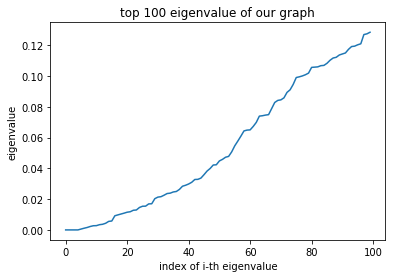

In [105]:
plt.plot(e)
plt.xlabel('index of i-th eigenvalue')
plt.ylabel('eigenvalue')
plt.title('top 100 eigenvalue of our graph')

In [106]:
X = U[:,0:n_k_means]

k_means = KMeans(init='k-means++', n_clusters=n_k_means, n_init=10)
k_means.fit(X)

k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis=0)
k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)

Text(0.5,1,'Spectral graph of first and second eigenvectors (zoomed in)')

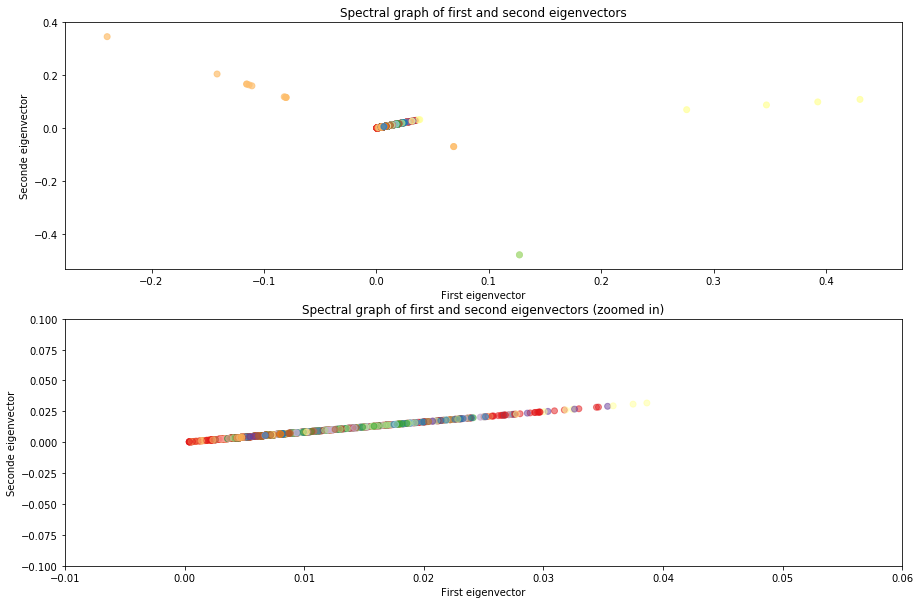

In [108]:
cmap = plt.get_cmap('Paired',n_k_means)

fig, ax = plt.subplots(2,1,figsize=(15,10))
ax[0].scatter(U[:,1],U[:,2],c=k_means_labels,alpha=0.7,cmap=cmap)
ax[0].set_xlabel('First eigenvector')
ax[0].set_ylabel('Seconde eigenvector')
ax[0].set_title('Spectral graph of first and second eigenvectors')
#plt.colorbar()
ax[1].scatter(U[:,1],U[:,2],c=k_means_labels,alpha=0.5,cmap=cmap)
ax[1].set_xlabel('First eigenvector')
ax[1].set_ylabel('Seconde eigenvector')
ax[1].set_xlim(-0.01,0.06)
ax[1].set_ylim(-0.1,0.1)
ax[1].set_title('Spectral graph of first and second eigenvectors (zoomed in)')


The drawing shows that approximately airports are clustered to their neighbourhoods, and we can see the cluster approximately shows the continents and countries ( eg Eastern Asia, Europe, US and Africa).

**We may say that, the world is connected, but it is still separated into small regions.**

In [92]:
pos_dict = {}
portgeo.set_index('IATA',inplace=True)
for node_IATA in list(G.node):
    try:
        longitude = portgeo.loc[node_IATA].Longitude
        latitude = portgeo.loc[node_IATA].Latitude
    except:
        longitude = 0
        latitude = 0        
    pos_dict[node_IATA] = longitude,latitude
portgeo.reset_index(inplace=True)

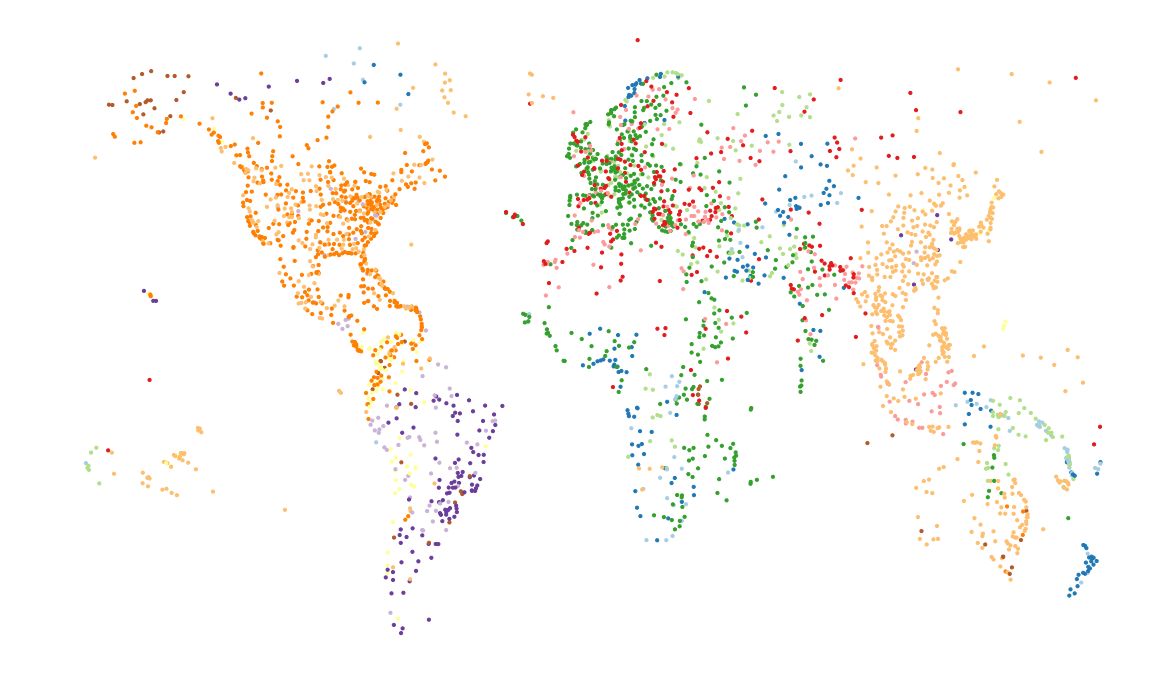

In [99]:
fig, ax = plt.subplots(figsize=(20,12))

nx.draw(G,pos=pos_dict,node_size=10,width=0,node_color=k_means_labels,cmap=cmap)

Go back to [Table of contents](#Table-of-contents)